<a href="https://colab.research.google.com/github/chad-fisher/CRWA-Regional-Tree-Planting-and-Protection-Plan/blob/main/CodeNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

In [119]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx
import ee
import geemap
import geemap.foliumap as geemapf

In [120]:
#Authenticate to Earth Engine
ee.Authenticate()

True

In [121]:
#Assign working directory
!cd "C:/Users/chadl/OneDrive/Desktop/CRWA Project"

In [122]:
#Initialize earth engine project
ee.Initialize(project='ee-cefisher20')

# Miscellaneous tools

In [93]:
#Extracting hex codes from matplotlib color maps 
blues = mpl.colormaps['Blues'].resampled(6)
for i in range(0,6):
    print(mpl.colors.to_hex(blues(i)))

#f7fbff
#d0e1f2
#94c4df
#4a98c9
#1764ab
#08306b


# Extracting watershed boundaries

In [58]:
#HUC codes from https://apps.nationalmap.gov/viewer/
Charles=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000107' or huc10 == '0109000106'")
Charles_lower=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000107'")
Charles_upper=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000106'")

In [83]:
#Convert earth engine feature collections to geopandas data frames
Charles_gdf = ee.data.computeFeatures({
    'expression': Charles,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_gdf.crs = 'EPSG:4326'

Charles_lower_gdf = ee.data.computeFeatures({
    'expression': Charles_lower,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_lower_gdf.crs = 'EPSG:4326'

Charles_upper_gdf = ee.data.computeFeatures({
    'expression': Charles_upper,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_upper_gdf.crs = 'EPSG:4326'

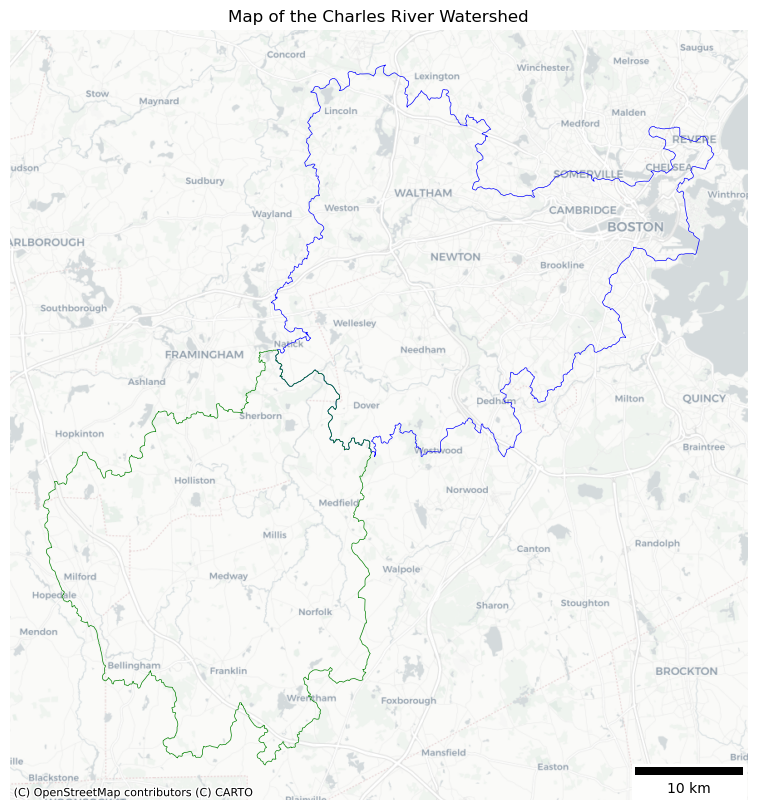

In [89]:
ax = Charles_lower_gdf.to_crs(epsg=3857).boundary.plot(figsize=(10,10), color='blue',linewidth=0.5)
Charles_upper_gdf.to_crs(epsg=3857).boundary.plot(ax=ax,figsize=(10,10), color='green',linewidth=0.5)
plt.title("Map of the Charles River Watershed")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig("CRWA-Regional-Tree-Planting-and-Protection-Plan\Charles Watershed Maps.png")

# Forest Cover Animation

In [90]:
#Create function to clip image to be used for clipping image collections 
def Charclip(image):
    return image.clip(Charles)

In [91]:
#Import and clip MODIS VCF data to Charles and animate
treeData=ee.ImageCollection('MODIS/006/MOD44B').filterBounds(Charles.geometry()).select('Percent_Tree_Cover').map(Charclip)
videoArgs = {
  'dimensions': 768,
  'region': Charles.geometry(),
  'framesPerSecond': 2,
  'crs': 'EPSG:3857',
  'min': 0,
  'max': 100,
  'palette': ["#f7fcf5","#c7e9c0","#74c476","#238b45","#00441b"]
}

In [92]:
#Obtain link to animation 
print(treeData.getVideoThumbURL(videoArgs))

https://earthengine.googleapis.com/v1/projects/ee-cefisher20/videoThumbnails/ea9d4b4ce9b04783baa1b1052e930452-27fa29b8e6070a07d79633ab1d579a14:getPixels


# Forest Cover Maps

In [131]:
for i in range(2000,2021):
    year=i
    image=ee.ImageCollection('MODIS/006/MOD44B').filterDate(str(i)+'-01-01',str(i+1)+'-01-01').map(Charclip)
    image_viz_params = {
        'bands': ['Percent_Tree_Cover'],
        'min': 0,
        'max': 100,
        'palette': 'Greens'
    }
    map_1 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
    map_1.add_layer(image, image_viz_params)
    legend_keys=['0%','25%','50%','75%','100%']
    map_1.add_legend('Percent_Tree_Cover',legend_keys,["#f7fcf5","#c7e9c0","#74c476","#238b45","#00441b"])
    map_1
    map_1.save('CRWA-Regional-Tree-Planting-and-Protection-Plan\Tree Cover '+str(i)+'.html')

    
########### Need to figure out how to export as static maps not HTMLs #################

# Scratch workspace

<Axes: >

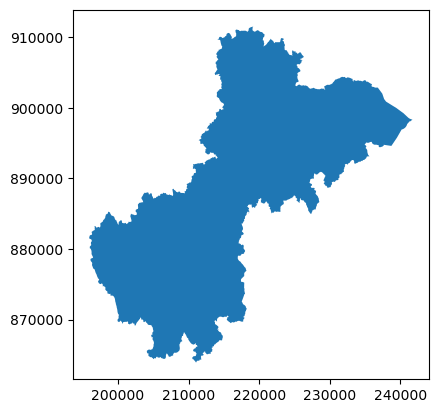

In [10]:
#Extracting Charles River Watershed Boundary
CRW_ = gpd.read_file("Raw_Data\watshd\watshdp1.shp")
CRW = CRW_[CRW_.NAME=="CHARLES"]
CRW.plot()

In [11]:
Ag_soils = gpd.clip(gpd.read_file("Raw_Data\Soils_MassGIS_SHP\SOILS_POLY_PRIMEFARMLAND.shp",mask=CRW),CRW)

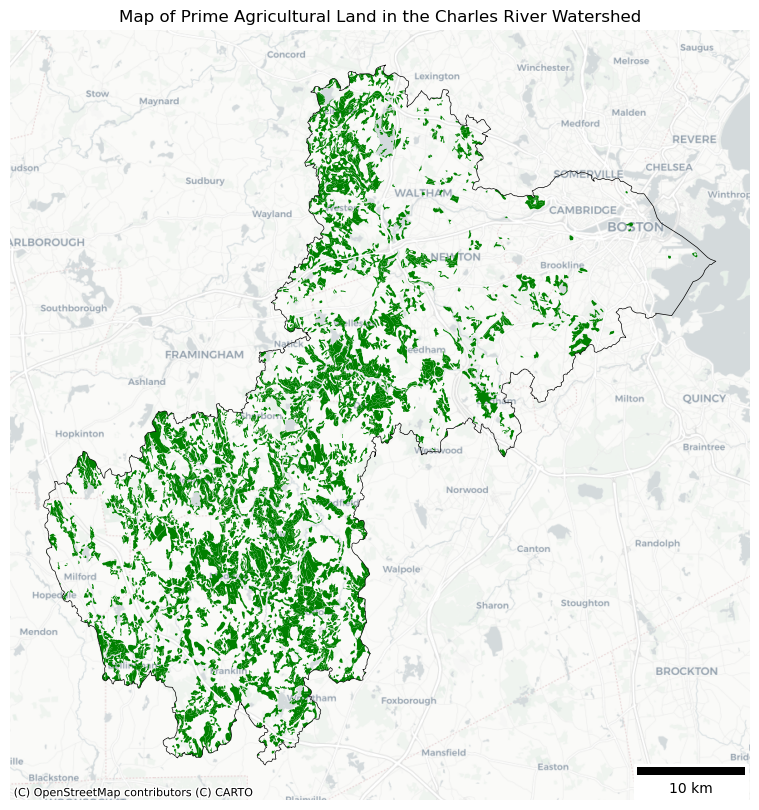

In [12]:
ax = Ag_soils.to_crs(epsg=3857).plot(figsize=(10,10),color='green')
CRW.to_crs(epsg=3857).boundary.plot(ax=ax, color='black',linewidth=0.5)
plt.title("Map of Prime Agricultural Land in the Charles River Watershed")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig("CRWA-Regional-Tree-Planting-and-Protection-Plan\AgLandCRW.png")

In [13]:
Soils = gpd.clip(gpd.read_file("Raw_Data\Soils_MassGIS_SHP\SOILS_MUPOLYGON_TOP20.shp",mask=CRW),CRW)

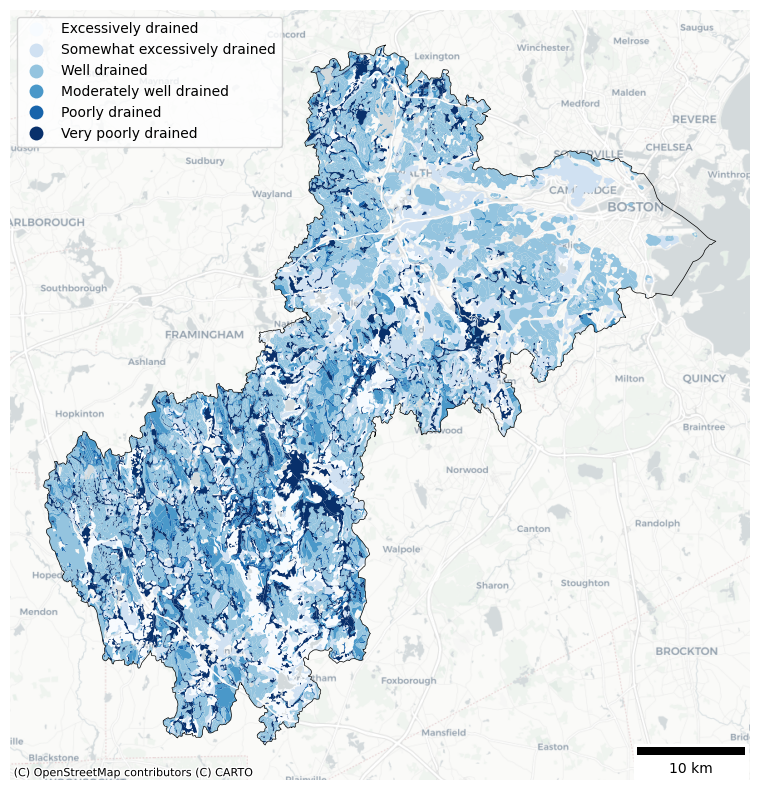

In [18]:
drain_int={
    'Excessively drained': 'A',
    'Somewhat excessively drained': 'B',
    'Well drained': 'C',
    'Moderately well drained': 'D',
    'Poorly drained': 'E',
    'Very poorly drained': 'F'
}
Soils['Drain_Code']=Soils['DRAINCLASS'].map(drain_int)
ax=Soils.to_crs(epsg=3857).plot(column='Drain_Code',cmap='Blues',legend=True,legend_kwds={'loc':'upper left'},figsize=(10,10))
leg1 = ax.get_legend()
new_legtxt = ['Excessively drained','Somewhat excessively drained','Well drained','Moderately well drained','Poorly drained','Very poorly drained']
for ix,eb in enumerate(leg1.get_texts()):
    eb.set_text(new_legtxt[ix])
CRW.to_crs(epsg=3857).boundary.plot(ax=ax, color='black',linewidth=0.5)
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.add_artist(ScaleBar(1,location='lower right'))
ax.set_axis_off()
plt.savefig("CRWA-Regional-Tree-Planting-and-Protection-Plan\Drainage.png")

In [129]:
NLCD2019=ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019').clip(Charles).select('landcover')
map_1 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_1.add_layer(NLCD2019.updateMask(NLCD2019.eq(41)),name='Deciduous Forest',color='light green')
map_1.add_layer(NLCD2019.updateMask(NLCD2019.eq(42)),name='Evergreen Forest',color='dark green')
map_1.add_layer(NLCD2019.updateMask(NLCD2019.eq(43)),name='Mixed Forest',color='green')
map_1

In [130]:
NLCD2019=ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019').clip(Charles).select('impervious')
map_2 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
image_viz_params = {
    'bands': ['impervious'],
    'min': 0,
    'max': 100,
    'palette': 'plasma'
}
map_2.add_layer(NLCD2019, image_viz_params)
map_2